In [43]:
!pip install plotly
!pip install cufflinks

     |████████████████████████████████| 23.9 MB 24.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 81 kB 12.9 MB/s eta 0:00:01
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67922 sha256=c23a6bca41e981609c637e63889a396de76c48a32a3ac87c41e86b32b8d7e437
  Stored in directory: /aiffel/.cache/pip/wheels/e1/27/13/3fe67fa7ea7be444b831d117220b3b586b872c9acd4df480d0
Successfully built cufflinks
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [44]:
pip install plotly --upgrade

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [88]:
import os
import re
import time
import nltk
import warnings
import numpy as np
import pandas as pd
import urllib.request
import missingno as msno
import plotly.express as px
import multiprocessing as mp
import matplotlib.pyplot as plt

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
import urllib.request
from attention import AttentionLayer
from bs4 import BeautifulSoup 
from functools import partial
from multiprocessing import Pool
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate

nltk.download('stopwords')
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. News Data load

> 뉴스 기사 데이터가 저장된 'news_summary_more.csv' 데이터를 CSV 형식으로 읽은 후, 데이터의 내용을 확인한다.

In [2]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
53628,Samsung surpasses Intel to become 2017's large...,South Korean electronics giant Samsung has bec...
66820,Burger King uses horror film 'IT' to troll McD...,Fast-food giant Burger King used horror movie ...
11068,RBI Governor gets notice on wilful defaulters'...,The Central Information Commission (CIC) issue...
35139,Hyd journalist booked over cartoon slamming Ra...,A Hyderabad-based journalist has been booked f...
23633,Maneka apologises for calling transgenders 'ot...,Women and Child Development Minister Maneka Ga...
5415,Obama surprises kids at children's hospital dr...,Former US President Barack Obama paid a surpri...
27635,"Israel stealing clouds, causing drought: Irani...",Head of Iran's Civil Defence Organisation Brig...
48201,Shame on Mohan Bhagwat for disrespecting Army:...,Congress President Rahul Gandhi on Monday slam...
21264,Reduce Mullaperiyar dam water level amid Keral...,"Amid the floods in Kerala, the Supreme Court o..."
62238,Case filed against dead man for damaging attac...,"A case has been filed against a farmer, who di..."


> 불러온 데이터를 확인한 결과 아래와 같은 정보를 획득했다.<br>
> 1. 헤드라인(제목), 텍스트(내용)으로, 2가지 정보를 가지고 있다.<br>
> 2. 뉴스 데이터는 총 98401개이다.

> 추상적 요약에 사용할 데이터는 별도로 저장해둔다

In [4]:
summarize_data = data['text']

# 2. Data EDA

> 모델 구성을 위해 데이터의 형태를 분석하고, 목적에 맞게 가공하는 과정을 진행한다.

## 2.1 데이터셋 내 문장 길이 분포

### 2.1.1 text data EDA

In [36]:
print("text 첫번째 문장 : {}\n".format(data['text'][0]))
print('1번째 뉴스 본문 길이: ', len(data['text'][0]))
print('2번째 뉴스 본문 길이: ', len(data['text'][1]))
print('29981번째 뉴스 본문 길이: ', len(data['text'][29980]))

text 첫번째 문장 : saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers

1번째 뉴스 본문 길이:  286
2번째 뉴스 본문 길이:  269
29981번째 뉴스 본문 길이:  225


> 임의의 문장을 추출하여 확인해보니 문장이 길이가 200~300 정도 되는것 같다.<br>
> 그러나, 검증된 표본의 개수가 너무 적어 신뢰할 수가 없다.<br>
> 때문에, 데이터 프레임을 활용해 데이터 세트 내 문장 길이 분포를 심층적으로 확인하는 과정을 진행한다.

In [40]:
sentence_len_list = []

for i in data['text']:
    sentence_len_list.append({'sentence_len' : len(i)})
    
text_df = pd.DataFrame(sentence_len_list)
text_df

,sentence_len
0,286
1,269
2,266
3,232
4,236
...,...
98355,270
98356,254
98357,237
98358,250


> 뉴스 본문 문장 길이 데이터의 중복을 제거하고 각 문장 길이당 개수를 구하면 아래 표와 같다

In [48]:
x = text_df['sentence_len'].value_counts().reset_index()
x

,index,sentence_len
0,253,1227
1,250,1219
2,245,1210
3,252,1198
4,248,1196
...,...,...
220,133,1
221,141,1
222,140,1
223,119,1


> 위 결과를 선형 그래프와 점 그래프로 시각화하여 확인하면 아래 그림과 같다

In [49]:
fig = px.bar(x, x='index', y='sentence_len')
fig.show()

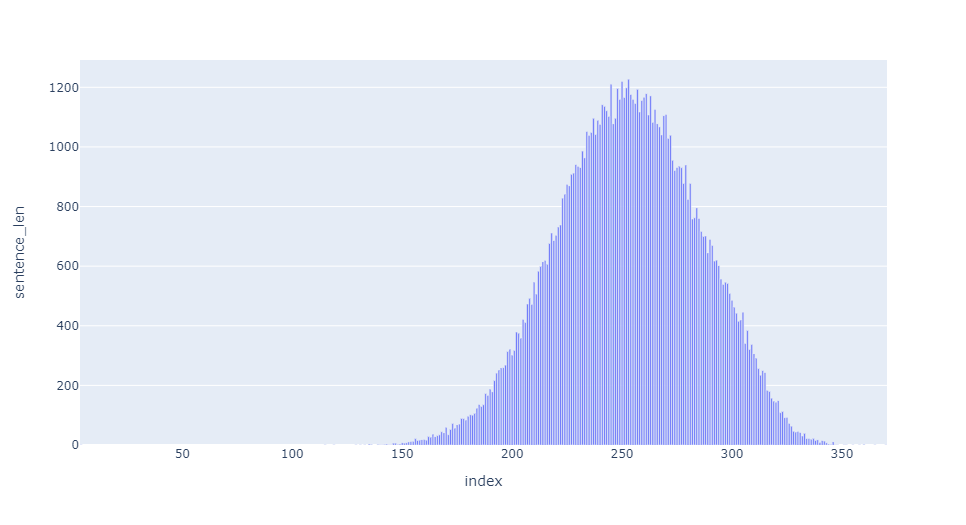

In [50]:
fig = px.scatter(x=x['index'], y=x['sentence_len'])
fig.show()

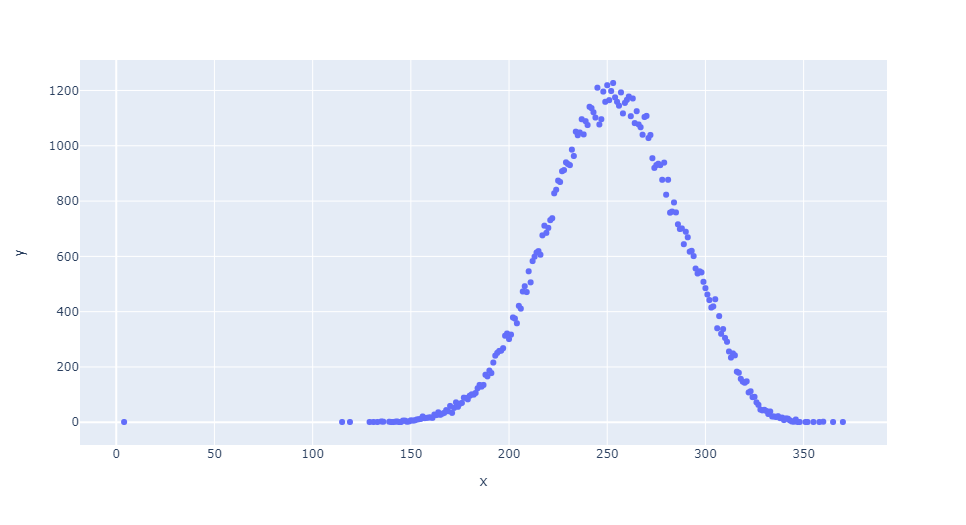

> 데이터가 문장 길이 250을 기준으로 정규 분포의 형태로 이루어져 있음을 확인할 수 있다.

### 2.1.2 headlines data EDA

In [52]:
print("headline 첫번째 문장 : {}\n".format(data['headlines'][0]))
print('1번째 뉴스 제목 길이: ', len(data['headlines'][0]))
print('2번째 뉴스 제목 길이: ', len(data['headlines'][1]))
print('29981번째 뉴스 제목 길이: ', len(data['headlines'][29980]))

headline 첫번째 문장 : upgrad learner switches to career in ml al with salary hike

1번째 뉴스 제목 길이:  59
2번째 뉴스 제목 길이:  60
29981번째 뉴스 제목 길이:  45


> 임의의 제목을 추출하여 확인해보니 뉴스 제목의 길이가 40~ 60정도 되는것 같다.<br>
> 그러나, 검증된 표본의 개수가 너무 적어 신뢰할 수가 없다.<br>
> 때문에, 데이터 프레임을 활용해 데이터 세트 내 문장 길이 분포를 심층적으로 확인하는 과정을 진행한다.

In [53]:
sentence_len_list = []

for i in data['headlines']:
    sentence_len_list.append({'sentence_len' : len(i)})
    
headlines_df = pd.DataFrame(sentence_len_list)
headlines_df

,sentence_len
0,59
1,60
2,59
3,56
4,65
...,...
98355,51
98356,54
98357,37
98358,58


> 뉴스 제목의 문장 길이 데이터의 중복을 제거하고 각 문장 길이당 개수를 구하면 아래 표와 같다

In [54]:
x = headlines_df['sentence_len'].value_counts().reset_index()
x

,index,sentence_len
0,57,10136
1,56,9594
2,58,9134
3,55,8770
4,54,7745
5,59,7596
6,53,6506
7,52,5402
8,60,5160
9,51,4390


> 위 결과를 선형 그래프와 점 그래프로 시각화하여 확인하면 아래 그림과 같다

In [55]:
fig = px.bar(x, x='index', y='sentence_len')
fig.show()

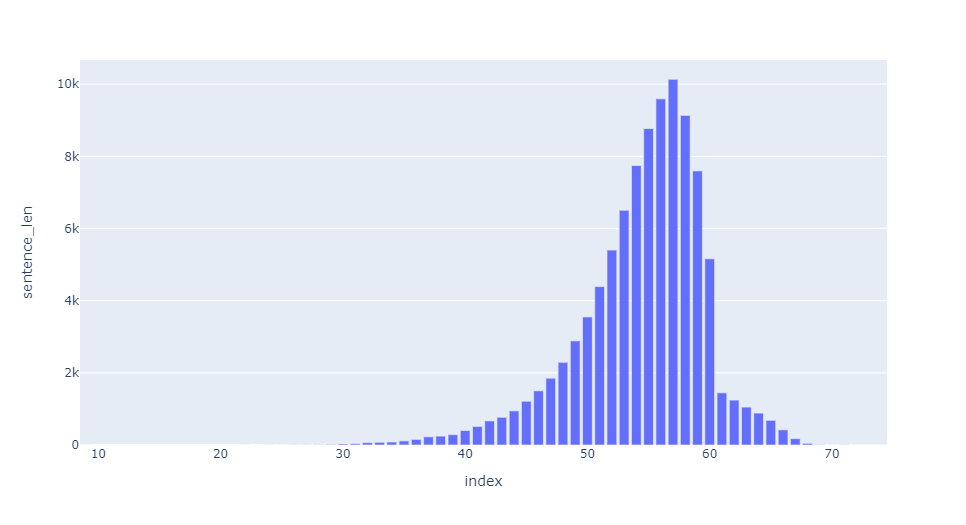

In [56]:
fig = px.scatter(x=x['index'], y=x['sentence_len'])
fig.show()

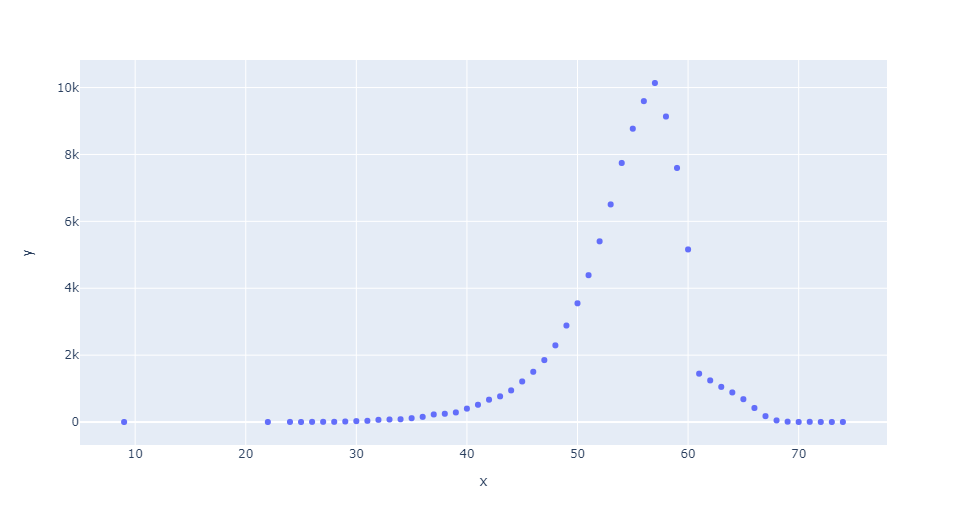

> 뉴스 제목 데이터는 문장 길이 57을 기준으로 정규 분포의 형태로 이루어져 있음을 확인할 수 있다.<br>
> 제목 길이 40부터 급격하게 빈도가 증가하다가 60이상부터는 빈도가 급감하는 모습을 보여준다.

# 2. News data preprocessing

## 2.1 Check missing values

> 불러온 데이터에 결측치가 있는지 확인하는 작업을 수행한다.

<AxesSubplot:>

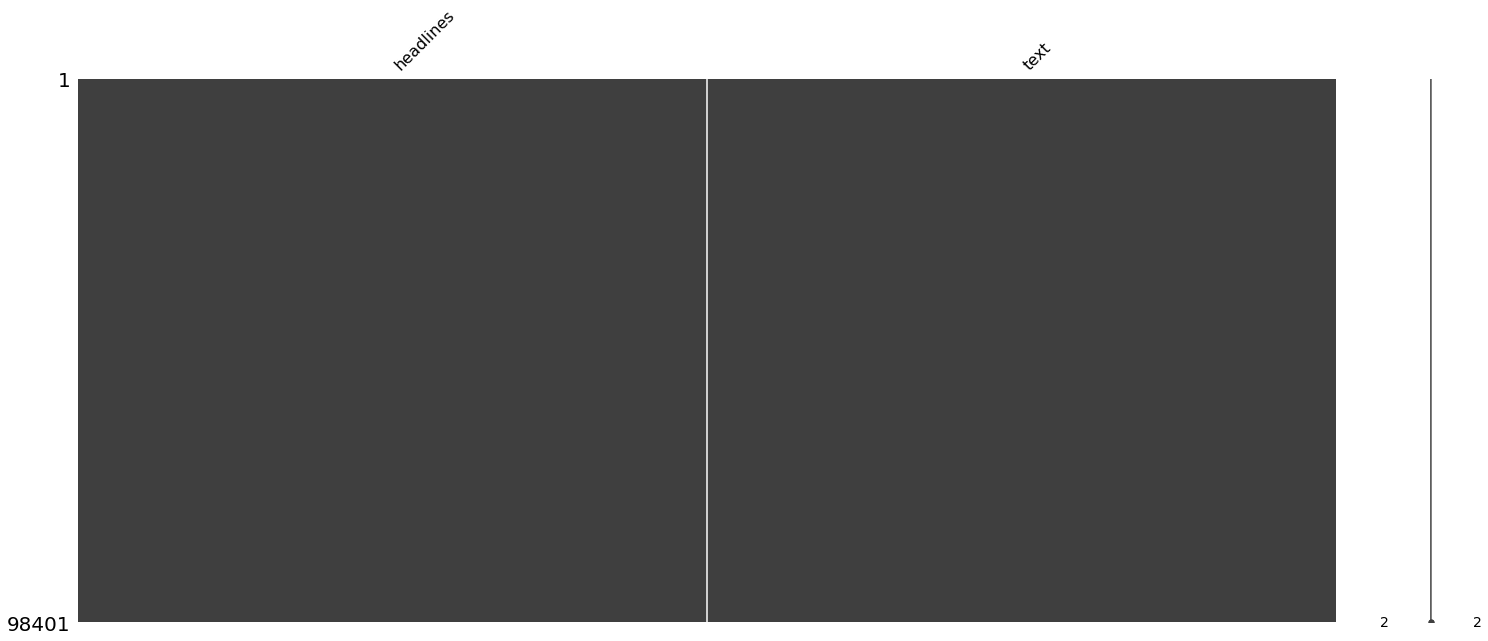

In [7]:
msno.matrix(data)

<AxesSubplot:>

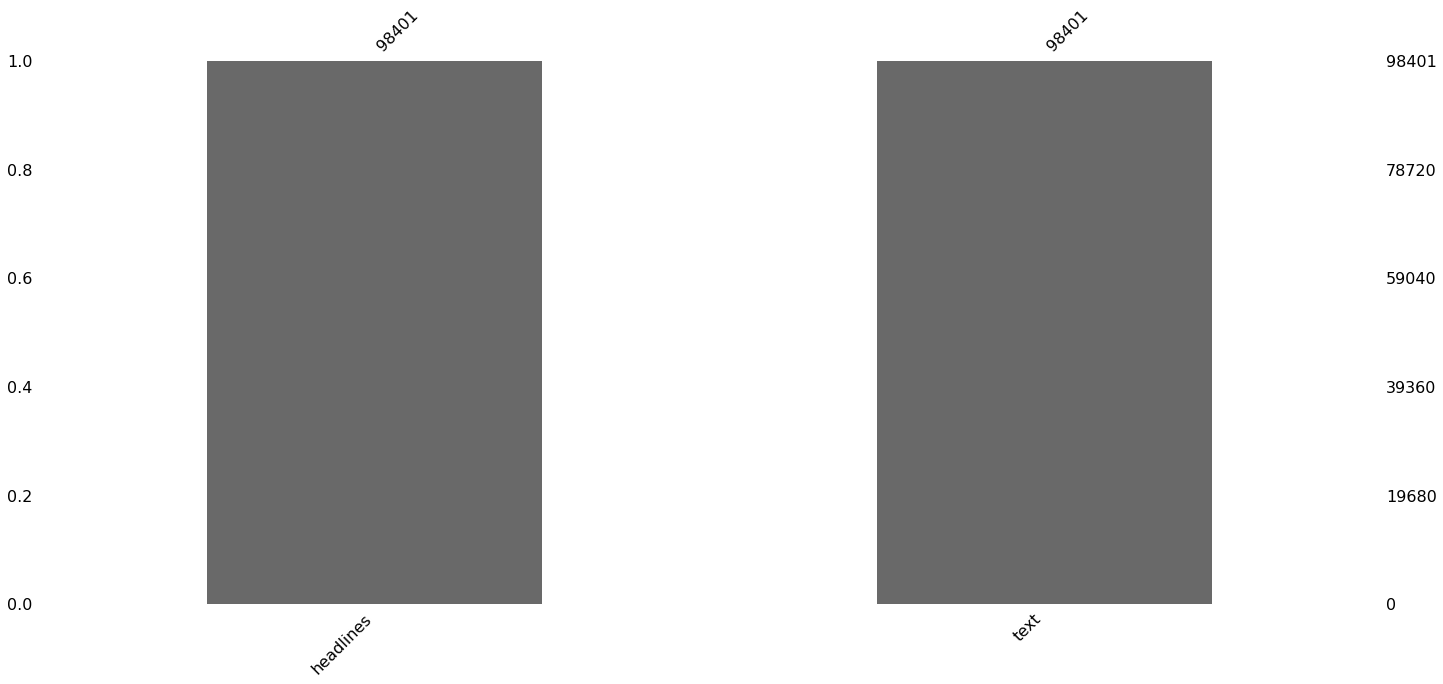

In [9]:
msno.bar(data)

> 뉴스 데이터를 시각적, 수치적 분석을 진행한 결과 결측치가 확인되지 않았다.

## 2.2 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [12]:
print('headlines 컬럼에서 중복을 배제한 유일한 데이터의 수 :', data['headlines'].nunique())
print('text 컬럼에서 중복을 배제한 유일한 데이터의 수 :', data['text'].nunique())

headlines 컬럼에서 중복을 배제한 유일한 데이터의 수 : 98280
text 컬럼에서 중복을 배제한 유일한 데이터의 수 : 98360


> 98401개의 데이터 중 대부분의 데이터가 유니크한 데이터임을 확인할 수 있다.<br>
> 텍스트가 전달하고자 하는 정보는 중복되어 있을 수 있음을 인지하고 작업을 진행한다.<br>
> 데이터프레임의 drop_duplicates()를 활용하여, 중복 샘플을 제거하는 작업을 수행한다<br>

In [17]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복 데이터 제거 작업 후 text 데이터 수 :', (len(data)))

중복 데이터 제거 작업 후 text 데이터 수 : 98360


> 데이터프레임에 Null 값이 있는지 확인하기 위해 .isnull().sum()을 활용한다.

In [15]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


>  데이터프레임에서 Null을 제거하기 위해 dropna() 함수를 사용한다

In [18]:
data.dropna(axis=0, inplace=True)
print('null 제거 후 text 컬럼 전체 데이터 수 :', (len(data)))

null 제거 후 text 컬럼 전체 데이터 수 : 98360


## 2.3 Text normalization and  remove stopword

### 2.3.1 Text normalization

> 학습 복잡도 감소를 위해 같은 의미이나 다른 표현 쓰이는 단어를 일원화 하는 과정을 진행한다.<br>
> 데이터가 영문 텍스트 이므로 영문 기반 정규화 작업을 진행한다.

In [20]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화에 사용된 단어 개수: ", len(contractions))

정규화에 사용된 단어 개수:  120


### 2.3.2 remove stopword

> 학습 복잡도 감소를 위해 자연어 기반 훈련에 비효율적인 단어를 제거한다. 이는 성능을 높이는 방법 중 하나이다<br>
> NLTK 라이브러리에서 제공하는 불용어 리스트를 활용하여 불용어를 제거한다.

In [21]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

> 훈련 모델이 필요한 내용만 학습할 수 있도록 데이터의 규격을 일원화 하기 위해 다음과 같은 작업을 수행하는 함수를 구현한다.<br>
> 1. 모든 영어 문자는 소문자 변경한다.
> 2. 텍스트에 존재하는 html 태그를 제거한다.
> 3. 각종 특수문자를 제거한다.
> 4. 줄임말, 감탄사 등의 비표준어를 정제한다.

In [22]:
def preprocess_sentence(sentence, remove_stopwords=True):
    
    # step1. 텍스트 소문자화
    sentence = sentence.lower()
    
    # step2. html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    
    # step3. 괄호로 닫힌 문자열 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    
    # step4. 쌍따옴표 " 제거
    sentence = re.sub('"','', sentence)
    
    # step5. 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    
    # step6. 소유격 제거
    sentence = re.sub(r"'s\b","", sentence)
    
    # step7. 영어 외 문자(숫자, 특수문자 등은 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    
    # step8. 감탄사 m이 3개 이상이면 2개로 변경
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # step9. 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        
    return tokens

> 정규화 기능 확인을 위한 예문 입력

In [24]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = '"Great way" to start (or finish) the day!!! ummmmmy!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headline, False))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day ummy


> 각종 html, 특수문자, 감탄사 등을 모두 잘 처리했음을 확인할 수 있다.<br>
> 위 기능을 활용하여 모든 데이터를 전처리하는 작업을 수행한다.

### 2.3.3 Text and headline preprocessing

> 전처리 작업시간을 줄이기 위해 멀티 스레딩을 활용하여 작업을 진행한다.

In [25]:
start = time.time()

def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()
    
    text_data_split = np.array_split(data, num_cores)
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False)
print(clean_summary)

429.6426067352295  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

> 멀티프로세싱으로 전처리 작업 수행에 약 430초가 소요되었다.

In [27]:
pre_text = clean_text
pre_headline = clean_summary

del clean_text
del clean_summary

> 텍스트 정제 후 empty 데이터가 생성되었는지 확인하는 작업을 수행한다.<br>
> empty 데이터는 Null 값으로 교체한다.

In [29]:
data['text'] = pre_text
data['headlines'] = pre_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [30]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [32]:
data.dropna(axis=0, inplace=True)
print('데이터 수 :', (len(data)))

데이터 수 : 98360


## 2.4 Make dataset

### 2.4.1 샘플의 최대 길이 정하기

> 위 2. data EDA 항목에서 시각화 작업을 통해, 뉴스 제목과 본문 데이터 모두 분포가 정규분포 형태임을 확인했다.<br>
> 또한 두 데이터의 분포 형태도 매우 흡사함을 확인할 수 있었다.<br>
> 위 결과를 바탕으로 적절한 최대 문장 길이를 지정하는 작업을 진행한다.

뉴스 본문의 최소 길이 : 1
뉴스 본문의 최대 길이 : 60
뉴스 본문의 평균 길이 : 35.09968483123221

뉴스 제목의 최소 길이 : 1
뉴스 제목의 최대 길이 : 16
뉴스 제목의 평균 길이 : 9.299532330215534


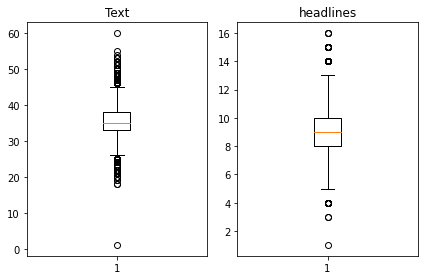

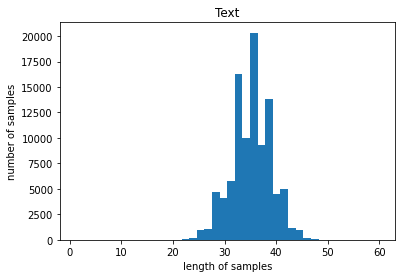

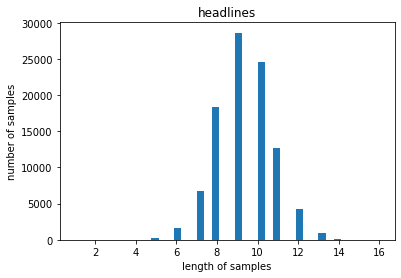

In [60]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('뉴스 본문의 최소 길이 : {}'.format(np.min(text_len)))
print('뉴스 본문의 최대 길이 : {}'.format(np.max(text_len)))
print('뉴스 본문의 평균 길이 : {}\n'.format(np.mean(text_len)))
print('뉴스 제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('뉴스 제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('뉴스 제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

> 위 결과를 통해, 전처리 이후의 데이터도 대체로 정규분포의 형태를 띄는 모습을 보여주었다.<br>
> 그러나 이상치도 같이 관측되었다. 이상치로 인한 데이터 학습의 저하를 방지하기 위해<br>
> Text의 최대 길이와 Summary의 적절한 최대 길이를 계산하여 임의로 일정 길이로 설정하는 작업을 수행한다.

In [65]:
def below_threshold_len(min_len, max_len, data_kind, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len and len(s.split()) >= min_len):
            cnt = cnt + 1
    print('문장 길이가 {}이상, {} 이하인 {}데이터의 비율: {}'.format(min_len, max_len, data_kind,(cnt / len(nested_list))))

In [68]:
text_len_min = 25
text_len_max = 45

headlines_len_min = 6
headlines_len_max = 12

In [69]:
below_threshold_len(text_len_min, text_len_max, 'text', data['text'])
below_threshold_len(headlines_len_min, headlines_len_max, 'headlines', data['headlines'])

문장 길이가 25이상, 45 이하인 text데이터의 비율: 0.994408296055307
문장 길이가 6이상, 12 이하인 headlines데이터의 비율: 0.9855734038226922


> 제목, 본문 데이터 모두 98.5%이상 학습 조건에 해당되는 문잘 길이 범위 안에 해당되었다.<br>
> 위 조건에 맞지 않는 데이터는 제외하는 작업을 진행한다.

In [71]:
data = data[data['text'].apply(lambda x: (len(x.split()) <= text_len_max and len(x.split()) >= text_len_min))]
data = data[data['headlines'].apply(lambda x: (len(x.split()) <= headlines_len_max and len(x.split()) >= headlines_len_min))]
print('뉴스 기사 데이터 수 :', (len(data)))

뉴스 기사 데이터 수 : 96403


> 기존 98360개의 데이터 중 조건에 부합한 데이터를 총 96403개 확보했다.

### 2.4.2 시작 토큰과 종료 토큰 추가하기

> 모델이 문장의 시작과 끝을 알 수 있도록, 시작 신호는 'sostoken', 종료 신호는 'eostoken'으로 토큰을 추가하는 작업을 진행한다.

In [72]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


>  디코더의 입력과 레이블은 각각 다시 Numpy 타입으로 저장한다

In [73]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

> 훈련용 데이터와 테스트용 데이터를 분리후 랜덤으로 섞는다.

In [74]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[38896 32180 12453 ... 24288 72382 61752]


> 정수 값를 활용해 다시 데이터의 샘플 순서를 재정의하여 이전보다 더욱 랜덤한 데이터를 얻는 작업을 진행한다.

In [31]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

>  8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하는 작업을 진행한다.

In [75]:
n_of_val = int(len(encoder_input)*0.2)
print('text_data_len :', n_of_val)

text_data_len : 19280


>  테스트용 데이터의 개수를 이용해 인코더와 디코더용 입력 데이터를 생성을 작업을 진행한다.

In [77]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련용 인코더 입력 데이터의 개수 :', len(encoder_input_train))
print('훈련용 디코더 입력 데이터의 개수 :', len(decoder_input_train))
print('테스트용 인코더 입력 데이터의 개수 :', len(encoder_input_test))
print('테스트용 디코더 입력 데이터의 개수 :', len(decoder_input_test))

훈련용 인코더 입력 데이터의 개수 : 77123
훈련용 디코더 입력 데이터의 개수 : 77123
테스트용 인코더 입력 데이터의 개수 : 19280
테스트용 디코더 입력 데이터의 개수 : 19280


## 2.3 정수 인코딩

## 2.3.1 단어 집합(vocabulary) 만들기 및 정수 인코딩

### 2.3.1.1 make vocabulary for text data

> 훈련 모델이 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다<br>
> 이를 위해 단어에 고유한 정수를 맵핑하는 작업인 단어 집합(vocabulary) 과정을 수행한다.

In [78]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

> 단어 집합이 생성하여, 각 단어에 고유한 정수를 부여했다<br>
> 생성된 단어 집합은 src_tokenizer.word_index에 저장되어있다<br>
> 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행한다<br>
> src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다

In [84]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67568
등장 빈도가 6번 이하인 희귀 단어의 수: 45863
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21705
단어 집합에서 희귀 단어의 비율: 67.87680558844423
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.464977328765226


> 등장 빈도가 6회 이하인 단어들을 정수 인코딩 과정 제외하면, 단어의 집합 크기는 대략 22,000정도이다.<br>
> 이에 text 단어 집합 크기를 22,000으로 설정 후 단어 집합을 재생성하는 작업을 진행한다.

In [80]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

> texts_to_sequences()를 활용하여 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 작업을 수행한다

In [81]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6519, 6958, 8259, 10015, 8811, 1661, 1725, 1985, 1393, 624, 11609, 1712, 2325, 1273, 878, 22, 143, 1220, 1661, 8259, 2548, 611, 352, 967, 5004, 132, 3422, 2300, 1781, 1535, 2157, 8259, 208, 327, 1985, 2210, 62, 8406], [5582, 251, 1266, 1036, 538, 1408, 411, 20251, 597, 101, 2434, 231, 373, 341, 5438, 18, 2, 13542, 8557, 26, 20252, 3673, 2948, 2630, 20251, 4690, 101, 121, 18, 20251, 3532, 123, 2617, 538, 528, 100, 4515, 10278, 3629, 39, 14505, 21706, 11610, 2513], [25, 724, 844, 3, 699, 605, 274, 4606, 70, 231, 9, 89, 88, 89, 274, 146, 3, 262, 116, 89, 814, 240, 5439, 1288, 6678, 1341, 163, 408, 89, 1667, 3, 491, 2514, 2645, 317, 274, 115, 486]]


> 뉴스 제목에도 동일한 작업을 수행한다

### 2.3.1.2 make vocabulary for headline data

In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [39]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10521
등장 빈도가 5번 이하인 희귀 단어의 수: 8147
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2374
단어 집합에서 희귀 단어의 비율: 77.43560498051517
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.915184348096133


> 등장 빈도가 4회 단어들을 정수 인코딩 과정 제외하면, 단어의 집합 크기는 대략 2400정도이다.<br>
> 이에 headlines 단어 집합 크기는 2400으로 설정 후 단어 집합을 재생성하는 작업을 진행한다

In [85]:
tar_vocab = 2400
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 722, 4, 1902, 9, 1121, 1108], [1, 26, 157, 247, 363, 14, 5, 127, 39, 7], [1, 40, 1233, 344, 452, 548, 500, 8, 160, 619], [1, 190, 1755, 491, 941, 1716, 850, 359], [1, 746, 170, 326, 681, 466, 5, 2016, 1903]]
target
decoder  [[3, 722, 4, 1902, 9, 1121, 1108, 2], [26, 157, 247, 363, 14, 5, 127, 39, 7, 2], [40, 1233, 344, 452, 548, 500, 8, 160, 619, 2], [190, 1755, 491, 941, 1716, 850, 359, 2], [746, 170, 326, 681, 466, 5, 2016, 1903, 2]]


> 뉴스 제목 데이터에서 길이가 0이 된 데이터들은 시작토큰과 종료토큰이 추가되어있어 실제로는  실제 길이는 1일것이다.<br>
> 때문에 headlines 데이터의 길이가 1인 데이터는 모두 삭제한다.

In [86]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련용 뉴스 제목 데이터의 개수 :', len(drop_train))
print('삭제할 테스트용 뉴스 제목 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련용 뉴스 제목 인코더 데이터의 개수 :', len(encoder_input_train))
print('훈련용 뉴스 제목 디코더 레이블의 개수 :', len(decoder_input_train))
print('테스트용 뉴스 제목 인코더 데이터의 개수 :', len(encoder_input_test))
print('테스트용 뉴스 제목 디코더 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련용 뉴스 제목 데이터의 개수 : 4
삭제할 테스트용 뉴스 제목 데이터의 개수 : 1


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



훈련용 뉴스 제목 인코더 데이터의 개수 : 77119
훈련용 뉴스 제목 디코더 레이블의 개수 : 77119
테스트용 뉴스 제목 인코더 데이터의 개수 : 19279
테스트용 뉴스 제목 디코더 레이블의 개수 : 19279


## 2.3.2 padding

In [87]:
# 훈련 & 테스트용 인코더 입력 데이터
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_len_max, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_len_max, padding='post')

# 훈련용 디코더 입력 데이터
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_len_max, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_len_max, padding='post')

# 테스트용 디코더 입력 데이터
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_len_max, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_len_max, padding='post')

# 3 모델 설계

> 자연어 처리에 큰 강점을 보이는 Seq2seq 기반 모델을 활용하여 인코더와 디코더 모델을 구현한다.

## 3.1 인코더모델 설계

> 인코더 모델은 LSTM을 활용하며, 총 3개의 레이어 층으로 구성해서 모델의 복잡도를 높였다.<br>
> recurrent dropout을 활용하여 time step의 입력을 랜덤으로 생략해줌으로써, regularization 효과와 과적합을 방지한다<br>

In [90]:
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_len_max,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 3.2 디코더모델 설계

> 디코더 출력에는 LSTM 모델의 initial_state 인자값으로 인코더의 hidden state와 cell state의 값을 넣어준다. <br>
> 출력층에서는 Headlines의 단어 집합에서 1개의 단어를 선택하는 분류 문제를 풀 수 있도록 소프트맥스를 설정한다<br>

In [91]:
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 3.3 어텐션 레이어 설계

In [92]:
attn_layer = AttentionLayer(name='attention_layer')

attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 4. 모델 훈련

In [93]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [94]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
302/302 [==============================] - 238s 747ms/step - loss: 4.4752 - val_loss: 3.6233
Epoch 2/50
302/302 [==============================] - 225s 744ms/step - loss: 3.7064 - val_loss: 3.3544
Epoch 3/50
302/302 [==============================] - 225s 746ms/step - loss: 3.3936 - val_loss: 3.1618
Epoch 4/50
302/302 [==============================] - 226s 748ms/step - loss: 3.1625 - val_loss: 3.0270
Epoch 5/50
302/302 [==============================] - 225s 747ms/step - loss: 2.9930 - val_loss: 2.9182
Epoch 6/50
302/302 [==============================] - 226s 748ms/step - loss: 2.8615 - val_loss: 2.8319
Epoch 7/50
302/302 [==============================] - 225s 746ms/step - loss: 2.7426 - val_loss: 2.7684
Epoch 8/50
302/302 [==============================] - 229s 760ms/step - loss: 2.6519 - val_loss: 2.7304
Epoch 9/50
302/302 [==============================] - 232s 768ms/step - loss: 2.5732 - val_loss: 2.6846
Epoch 10/50
302/302 [==============================] - 229s 757m

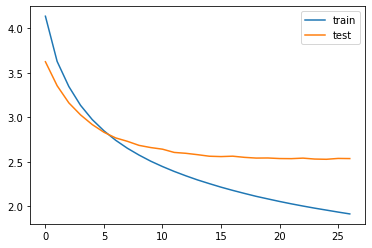

In [95]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

> 그래프는 안정적으로 수렴하는 모습을 보여주었으나, 과적합 현상이 있다.

# 5. 인퍼런스 모델 훈련

> 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원하기위해,<br>
> 문자는 정수로, 정수는 문자로 바꾸는 단어 사전을 구현한다.

In [97]:
src_index_to_word = src_tokenizer.index_word # 본문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 제목 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 제목 단어 집합에서 정수 -> 단어를 얻음

> 정답인 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 한다.<br>
> 이에, 인퍼런스를 위한 모델을 설계하며, 인코더 모델과 디코더 모델을 분리해서 설계한다

In [98]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

> 어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [100]:
decoder_hidden_state_input = Input(shape=(text_len_max, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])


decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

> 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 구현한다.

In [105]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_len_max-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 6. 추상적으로 요약하는 모델 테스트

> 이번 장에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하고자 한다.<br>
> 이를 위해 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다.<br>
> 뉴스 기사 본문의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외한다.<br>
> 뉴스 기사 제목의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [102]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

> 테스트 데이터 약 3개의 샘플에 대해서 실제 요약과 예측된 요약을 비교한다

In [111]:
for i in range(112, 115):
    print("뉴스 원문 :", seq2text(encoder_input_test[i]))
    print("실제 제목 :", seq2summary(decoder_input_test[i]))
    print("추상적 요약 제목 :", decode_sequence(encoder_input_test[i].reshape(1, text_len_max)))
    print("\n")

뉴스 원문 : punjab chief minister captain amarinder singh mother kaur passed away aged monday residence patiala prolonged illness last designated queen estate ruled dynasty last rites conducted tuesday morning according reports 
실제 제목 : punjab cm singh mother passes away 
추상적 요약 제목 :  punjab cm singh passes away at


뉴스 원문 : delhi indira gandhi international airport become transit point drug trade arrests airport far year officials said reportedly double corresponding number last year narcotics control bureau records show people arrested smuggling drugs year july compared two july 
실제 제목 : delhi is for drug officials 
추상적 요약 제목 :  delhi airport to get its first ever airport


뉴스 원문 : el salvador defender henry bit us player twisted corner second half teams gold cup quarterfinal match last week teammate darwin also caught biting us defender omar suspended six games three anti sporting behaviour 
실제 제목 : footballer and him during match 
추상적 요약 제목 :  player loses to player who won gold in us


> [Data1. 실제 제목]<br>
> 영문) punjab cm singh mother passes away<br>
> 한문) punjab cm singh의 어머니가 돌아가셨다.<br><br>
> [Data1. 모델 예측 제목]<br>
> 영문) punjab cm singh passes away at<br>
> 한문) punjab cm singh가 세상을 떠나다
<br><br>
> [Data2. 실제 제목]<br>
> 영문) delhi is for drug officials<br>
> 한문) delhi는 마약 관리들을 위한 것이다.<br><br>
> [Data2. 모델 예측 제목]<br>
> 영문) delhi airport to get its first ever airport<br>
> 한문) 델리 공항의 사상 첫 공항 도착
<br><br>
> [Data3. 실제 제목]<br>
> 영문) footballer and him during match<br>
> 한문) 경기중의 축구선수와 남자<br><br>
> [Data3. 모델 예측 제목]<br>
> 영문) player loses to player who won gold in us<br>
> 한문) 선수는 우리에게 금메달을 딴 선수에게 졌다.

> Data1의 경우엔 문법과 핵심 단어 모두 훌륭하게 예측했다.<br>
> Data2는 델리라는 핵심 단어와 세관에 마약 관리 업무를 유추하여 공항이라 말한게 아닐까 생각한다.<br>
> Data3은 선수라는 핵심단어에 집중하여 텍스트를 생성한듯 하다. 그러나 문법와 내용은 맞지 않다.

# 7. Summa 라이브러리를 활용한 모델 예측 실험

## 7.1 summa download

In [112]:
!pip list | grep summa

summa                         1.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [113]:
import requests
from summa.summarizer import summarize

> Summa 라이브러리의 성능을 확인해보기 위해 작업 초기에 별도로 저장했던 전처리가 안된 데이터를 활용하여 성능 실험을 진행한다.

In [119]:
summarize_data.sample(10)

50663    A group of activists on Wednesday launched a w...
49618    North Korea's flag was raised in South Korea o...
8016     RJD supremo Lalu Prasad Yadav's son Tej Pratap...
81233    The anti-Romeo squad in Uttar Pradesh, which d...
34553    Criticising PM Narendra Modi over the Centre's...
70882    Electric vehicle maker Tesla has remotely incr...
51165    The Supreme Court on Monday stayed proceedings...
93726    Geoff Thomas from Sydney, Australia has decora...
29099    An artificial intelligence system was able to ...
36747    Speaking about the Opposition's efforts to cre...
Name: text, dtype: object

## 7.2 use summarize 

> summarize()의 인자<br><br> 
> text (str) : 요약할 테스트.<br>
> ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
> words (int or None, optional) – 출력에 포함할 단어 수.<br>
> 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.<br>
> split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [141]:
summarize_data[1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

> 직접 만든 모델과 유사한 결과를 얻기 위해, 권장 제목 요약문의 길이는 text_len_max로 설정한다.

In [171]:
summarize(summarize_data[1], words=text_len_max)

'Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.\nUsers get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.'

> 본문 내용의 주요 정보를 잘 요약했다.

## 7.3 훈련 모델과 summa 모델 성능 비교 

> 직업 훈련한 모델과 summa 라이브러리 모델의 문법적 핵심단어 추출 성능을 비교하기 위해 연구표본 3개를 비교하는 실험을 진행했다.

In [200]:
for i in range(0, 3):
    print("전처리 전 뉴스 원문 :", summarize_data[78864+i])
    print("전처리 후 뉴스 원문 :", seq2text(encoder_input_test[i+1]))
    print("실제 제목 :", seq2summary(decoder_input_test[i+1]))
    print("훈련 모델이 예측한 제목 :", decode_sequence(encoder_input_test[i+1].reshape(1, text_len_max)))
    print("summa 모델이 예측한 제목 :", summarize(summarize_data[78864+i], words=20))
    print("\n")

전처리 전 뉴스 원문 : Barkha Dutt has slammed her former employer NDTV for calling its new form of journalism 'MoJo' (mobile journalism), which she claimed, appropriates her brand's name. Dutt tweeted she launched Mojo after leaving NDTV and some events have already taken place under the banner. "Isn't it wrong to appropriate someone's brand name & new form of journalism as yours," she tweeted.
전처리 후 뉴스 원문 : dutt slammed former employer ndtv calling new form journalism mojo claimed brand name dutt tweeted launched mojo leaving ndtv events already taken place banner wrong appropriate someone brand name new form journalism tweeted 
실제 제목 : dutt slams over use of brand name 
훈련 모델이 예측한 제목 :  sanjay dutt to launch in
summa 모델이 예측한 제목 : Barkha Dutt has slammed her former employer NDTV for calling its new form of journalism 'MoJo' (mobile journalism), which she claimed, appropriates her brand's name.


전처리 전 뉴스 원문 : Actress Anushka Sharma has said that she was less affected by the failure of her 201

> 1. [본문]<br>바르카 두트는 자신의 브랜드 이름을 딴 새로운 형태의 저널리즘을 '모조'(MoJo, 모바일 저널리즘)라고 불렀던 전직 고용주 NDTV를 맹비난했다. Dutt는 NDTV를 탈퇴한 후 트위터를 통해 Mojo를 시작했고 몇몇 이벤트들은 이미 배너 아래에서 일어났다. "누군가의 브랜드 이름과 새로운 형태의 저널리즘을 여러분의 것으로 사용하는 것은 잘못된 것이 아닙니다,"라고 그녀는 트위터를 통해 말했다.
<br><br>
> [실제 뉴스 제목]<br>상표명 사용에 대해 비난하다.<br>
> [훈련 모델의 예측 제목]<br>'sanjay dutt' ?에 출시하다.<br>
> [summa 모델의 예측 제목]<br>바르카 두트는 자신의 브랜드 이름을 딴 새로운 형태의 저널리즘을 '모조'(MoJo, 모바일 저널리즘)라고 불렀던 전직 고용주 NDTV를 맹비난했다..<br>
> [평가]<br>직접 훈련 모델은 dutt 라는 핵심단어에 집중하여 텍스트를 생성한듯 하다. 그러나 내용의 맥락은 맞지 않는 아쉬운 문장 완성도를 보여준다. 반면 summa 모델은 핵심 정보 추출과 문장 완성을 사람 못지 않게 잘 출력했다.

> 2. [본문]<br>여배우 Anushka Sharma는 영화의 주연 배우 Ranbir Kapoor에 비해 2015년 영화 'Bombay Velvet'의 실패로 인한 영향을 덜 받았다고 말했습니다. 이어 "하지만 '봄베이 벨벳'이 로지의 [아누쉬카 캐릭터]보다 쟈니의 [란비르 캐릭터] 영화였기 때문이기도 하다"고 덧붙였다. Anushka는 또한 Ranbir가 영화의 실패의 표적이 된 것은 불공정하다고 말했습니다.
<br><br>
> [실제 뉴스 제목]<br>봄베이 실패의 영향을 덜 받는 것은 ranbir anushka이다.<br>
> [훈련 모델의 예측 제목]<br>padmavati에서 katrina를 피하지 않는 anushka<br>
> [summa 모델의 예측 제목]<br>여배우 아누쉬카 샤르마는 그녀의 2015년 영화 '봄베이 벨벳'의 실패에 영향을 덜 받았다고 말했다. 이 영화의 주연 배우 란비르 카푸르와 비교해서 말이다.<br>
> [평가]<br>직접 훈련 모델은 anushka, katrina, padmavati와 같이 핵심 명사 단어에 집중하여 텍스트를 생성한듯 하다. 그러나 내용의 맥락은 맞지 않는 문법 완성도는 아쉬운 모습을 보여준다. 반면 summa 모델은 핵심 추출과 문장 완성을 잘 구현했다.

> 3. [본문]<br>검열위원장인 Pahlaj Nihalani는 그가 이사회의 의장직을 그만두도록 요청받았다는 보도에 응답하면서 정부로부터 그러한 계획을 들은 적이 없다고 말했다. 결정은 전적으로 정부에 맡깁니다. 지금 나가라고 한다면, 그렇게 하겠어요... 후임자에게 행운을 빌어주며, 신속하게"라고 그는 덧붙였다.
<br><br>
> [실제 뉴스 제목]<br>cbfc 치프는 그가 그만두라는 요청을 받았다는 보고에 응답한다.<br>
> [훈련 모델의 예측 제목]<br>이사회 이사회 이사회 최고권위자?<br>
> [summa 모델의 예측 제목]<br>결정은 전적으로 정부에 맡깁니다. 지금 나가라고 한다면, 그렇게 하겠어요...<br>
> [평가]<br>직접 훈련 모델은 이사회와 권위자라는 핵심 명사 단어에 집중하여 텍스트를 생성한듯 하다. 이번에도 문장 완성도는, 아 이번건 완성이 안됬다; summa 모델도 이번 문장은 어려웠는지 핵심 단어는 잘 추출했으나 문장을 매끄럽게 마무리하여 요약 하지 못했다.

# 후기

> 실습 결과, 직접 훈련한 모델은 대체로 핵심 단어에 집중하여 텍스트를 생성하는 모습을 보여주었습니다.<br>
> 이는 데이터 작업 및 인코더, 디코더 설계 시 단어를 중심으로 텍스트를 생성하는 구조는 구현했으나,<br>
> 맥락을 고려하여 텍스트를 생성하는 알고리듬은 전적으로 기계학습에 의존하여 이와같은 결과가 나왔다고 생각합니다.<br>
> 문장의 맥락은 강화학습 기법을 통해 보상제도로 알고리듬을 학습하면 위 문제를 개선할 수 있을것이라 생각합니다.